This doesn't work very well. Might be worth mentioning though.

In [1]:
import numpy as np
from collections import deque
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint

from coremdlr.viz import model_plots, CorePlotter
from coremdlr.models import NetworkModel
from coremdlr.datasets import FaciesDataset

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
wavenet_model_args = {
    'feature' : 'pseudoGR',
    'network' : 'wavenet',
    'summary' : False,
    'sequence_size' : 128,
    'network_args' : {
        'num_blocks' : 20,
        'block_filters' : 128,
        'residual_filters' : 64,
        'output_resolution' : 32,
        'dropout_rate' : 0.5,
    },
    'optimizer_args' : {
        'optimizer' : 'Adam',
    },
    'loss' : {'categorical_crossentropy': 0.25,
              'ordinal_squared_error': 0.75}
}

CHKPT_FNAME = 'temp_best_weights.h5'

wavenet_fit_args = {
    'batch_size' : 16,
    'epochs' : 20,
    'class_weighted' : True
}

well_names = ["205-21b-3", "204-20-6a","204-20-1Z", "204-24a-6", "204-19-6"]
test_well_names = ["204-19-6", "204-24a-6", "204-20-6a"]

In [4]:
results = {}

for resolution in [8, 32, 64, 128, 256]:

    for test_well in test_well_names:
    
        # Set up dataset
        train_wells = [w for w in well_names if w != test_well]
        
        fdset = FaciesDataset(train_wells, test_wells=[test_well],
                            features=["pseudoGR"],
                            pseudoGR_args={'features' : ['mean', 'var', 'p10', 'p90'], 
                                           'per_channel' : True},
                            label_resolution=resolution)
    
        fdset.load_or_generate_data()
    
        # Build and train and re-load weights
        wavenet_model_args['sequence_size'] = 32*128 // resolution
        wavenet_model_args['network_args']['output_resolution'] = resolution
    
        chkpt_callback = ModelCheckpoint(CHKPT_FNAME, monitor='val_loss', verbose=1,
                                        save_best_only=True, 
                                        save_weights_only=True)
        wavenet_fit_args['callbacks'] = [chkpt_callback]
    
        wnet_model = NetworkModel(fdset, model_args=wavenet_model_args)
        wnet_model.fit(fdset, **wavenet_fit_args)
    
        wnet_model.network.load_weights(CHKPT_FNAME)
        os.remove(CHKPT_FNAME)
    
        # Get test results
        results[test_well] = wnet_model.preds_dataframe(test_well)
        results[test_well]['label_resolution'] = fdset.label_resolution

Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (15363,)), ('top', (15363,)), ('base', (15363,)), ('pseudoGR', (15363, 8, 16))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (15491,)), ('top', (15491,)), ('base', (15491,)), ('pseudoGR', (15491, 8, 16))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (7670,)), ('top', (7670,)), ('base', (7670,)), ('pseudoGR', (7670, 8, 16))]
Loading Well:  204-24a-6  from

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (7540,)), ('top', (7540,)), ('base', (7540,)), ('pseudoGR', (7540, 8, 16))]
Shapes of `(batch_X, batch_y)`: (16, 4096, 16), (16, 512, 4)
Epoch 1/20
21/22 [===========================>..] - ETA: 0s - loss: 1.3680 - acc: 0.2677
Epoch 00001: val_loss improved from inf to 1.50676, saving model to temp_best_weights.h5
22/22 [==============================] - 28s 1s/step - loss: 1.3960 - acc: 0.2580 - val_loss: 1.5068 - val_acc: 0.1909
Epoch 2/20
21/22 [===========================>..] - ETA: 0s - loss: 0.8778 - acc: 0.3535
Epoch 00002: val_loss improved from 1.50676 to 0.81385, saving model to temp_best_weights.h5
22/22 [==============================] - 8s 371ms/step - loss: 0.8691 - acc: 0.3572 - val_loss: 0.8138 - val_acc: 0.4973
Epoch 3/20
21/22 [===========================>..] - ETA: 0s - loss: 0.6722 - 

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (15363,)), ('top', (15363,)), ('base', (15363,)), ('pseudoGR', (15363, 8, 16))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (15491,)), ('top', (15491,)), ('base', (15491,)), ('pseudoGR', (15491, 8, 16))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (7670,)), ('top', (7670,)), ('base', (7670,)), ('pseudoGR', (7670, 8, 16))]
Loading Well:  204-19-6  from 

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (52020,)), ('top', (52020,)), ('base', (52020,)), ('pseudoGR', (52020, 8, 16))]
Shapes of `(batch_X, batch_y)`: (16, 4096, 16), (16, 512, 4)
Epoch 1/20
10/11 [==========================>...] - ETA: 1s - loss: 1.1925 - acc: 0.3298
Epoch 00001: val_loss improved from inf to 1.62610, saving model to temp_best_weights.h5
11/11 [==============================] - 32s 3s/step - loss: 1.2088 - acc: 0.3413 - val_loss: 1.6261 - val_acc: 0.3011
Epoch 2/20
10/11 [==========================>...] - ETA: 0s - loss: 0.7266 - acc: 0.4394
Epoch 00002: val_loss improved from 1.62610 to 1.08490, saving model to temp_best_weights.h5
11/11 [==============================] - 7s 611ms/step - loss: 0.7135 - acc: 0.4428 - val_loss: 1.0849 - val_acc: 0.2018
Epoch 3/20
10/11 [==========================>...] - ETA: 0s - loss: 0.592

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (15363,)), ('top', (15363,)), ('base', (15363,)), ('pseudoGR', (15363, 8, 16))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (7670,)), ('top', (7670,)), ('base', (7670,)), ('pseudoGR', (7670, 8, 16))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (52020,)), ('top', (52020,)), ('base', (52020,)), ('pseudoGR', (52020, 8, 16))]
Loading Well:  204-19-6  from 

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (15491,)), ('top', (15491,)), ('base', (15491,)), ('pseudoGR', (15491, 8, 16))]
Shapes of `(batch_X, batch_y)`: (16, 4096, 16), (16, 512, 4)
Epoch 1/20
19/20 [===========================>..] - ETA: 1s - loss: 1.5584 - acc: 0.1723
Epoch 00001: val_loss improved from inf to 0.64559, saving model to temp_best_weights.h5
20/20 [==============================] - 39s 2s/step - loss: 1.5449 - acc: 0.1712 - val_loss: 0.6456 - val_acc: 0.4242
Epoch 2/20
19/20 [===========================>..] - ETA: 0s - loss: 0.7887 - acc: 0.4138
Epoch 00002: val_loss improved from 0.64559 to 0.45918, saving model to temp_best_weights.h5
20/20 [==============================] - 8s 403ms/step - loss: 0.7832 - acc: 0.4183 - val_loss: 0.4592 - val_acc: 0.4969
Epoch 3/20
19/20 [===========================>..] - ETA: 0s - loss: 0.702

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('pseudoGR', (3842, 32, 16))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (3873,)), ('top', (3873,)), ('base', (3873,)), ('pseudoGR', (3873, 32, 16))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('pseudoGR', (1917, 32, 16))]
Loading Well:  204-24a-6  from  /ho

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (1884,)), ('top', (1884,)), ('base', (1884,)), ('pseudoGR', (1884, 32, 16))]
Shapes of `(batch_X, batch_y)`: (16, 4096, 16), (16, 128, 4)
Epoch 1/20
21/22 [===========================>..] - ETA: 0s - loss: 1.6718 - acc: 0.2144
Epoch 00001: val_loss improved from inf to 1.97538, saving model to temp_best_weights.h5
22/22 [==============================] - 43s 2s/step - loss: 1.7055 - acc: 0.2107 - val_loss: 1.9754 - val_acc: 0.1540
Epoch 2/20
21/22 [===========================>..] - ETA: 0s - loss: 0.8611 - acc: 0.3576
Epoch 00002: val_loss improved from 1.97538 to 0.62308, saving model to temp_best_weights.h5
22/22 [==============================] - 8s 381ms/step - loss: 0.8713 - acc: 0.3638 - val_loss: 0.6231 - val_acc: 0.5586
Epoch 3/20
21/22 [===========================>..] - ETA: 0s - loss: 0.7271 -

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('pseudoGR', (3842, 32, 16))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (3873,)), ('top', (3873,)), ('base', (3873,)), ('pseudoGR', (3873, 32, 16))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('pseudoGR', (1917, 32, 16))]
Loading Well:  204-19-6  from  /hom

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (13006,)), ('top', (13006,)), ('base', (13006,)), ('pseudoGR', (13006, 32, 16))]
Shapes of `(batch_X, batch_y)`: (16, 4096, 16), (16, 128, 4)
Epoch 1/20
10/11 [==========================>...] - ETA: 1s - loss: 2.0068 - acc: 0.3085

Epoch 00001: val_loss improved from inf to 2.30678, saving model to temp_best_weights.h5
11/11 [==============================] - 48s 4s/step - loss: 1.9836 - acc: 0.2922 - val_loss: 2.3068 - val_acc: 0.1873
Epoch 2/20
10/11 [==========================>...] - ETA: 0s - loss: 0.8036 - acc: 0.4294
Epoch 00002: val_loss improved from 2.30678 to 1.14733, saving model to temp_best_weights.h5
11/11 [==============================] - 7s 668ms/step - loss: 0.7726 - acc: 0.4367 - val_loss: 1.1473 - val_acc: 0.3100
Epoch 3/20
10/11 [==========================>...] - ETA: 0s - loss: 0.5

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('pseudoGR', (3842, 32, 16))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('pseudoGR', (1917, 32, 16))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (13006,)), ('top', (13006,)), ('base', (13006,)), ('pseudoGR', (13006, 32, 16))]
Loading Well:  204-19-6  from  

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (3873,)), ('top', (3873,)), ('base', (3873,)), ('pseudoGR', (3873, 32, 16))]
Shapes of `(batch_X, batch_y)`: (16, 4096, 16), (16, 128, 4)
Epoch 1/20
19/20 [===========================>..] - ETA: 1s - loss: 2.4243 - acc: 0.2287
Epoch 00001: val_loss improved from inf to 0.85002, saving model to temp_best_weights.h5
20/20 [==============================] - 53s 3s/step - loss: 2.4328 - acc: 0.2267 - val_loss: 0.8500 - val_acc: 0.4245
Epoch 2/20
19/20 [===========================>..] - ETA: 0s - loss: 0.9930 - acc: 0.3359
Epoch 00002: val_loss improved from 0.85002 to 0.51091, saving model to temp_best_weights.h5
20/20 [==============================] - 8s 422ms/step - loss: 0.9736 - acc: 0.3510 - val_loss: 0.5109 - val_acc: 0.4216
Epoch 3/20
19/20 [===========================>..] - ETA: 0s - loss: 0.7716 -

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (1920,)), ('top', (1920,)), ('base', (1920,)), ('pseudoGR', (1920, 64, 16))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (1936,)), ('top', (1936,)), ('base', (1936,)), ('pseudoGR', (1936, 64, 16))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (957,)), ('top', (957,)), ('base', (957,)), ('pseudoGR', (957, 64, 16))]
Loading Well:  204-24a-6  from  /home/a

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (944,)), ('top', (944,)), ('base', (944,)), ('pseudoGR', (944, 64, 16))]
Shapes of `(batch_X, batch_y)`: (16, 4096, 16), (16, 64, 4)
Epoch 1/20
21/22 [===========================>..] - ETA: 1s - loss: 1.8208 - acc: 0.2335
Epoch 00001: val_loss improved from inf to 3.07684, saving model to temp_best_weights.h5
22/22 [==============================] - 58s 3s/step - loss: 1.9950 - acc: 0.2234 - val_loss: 3.0768 - val_acc: 0.1406
Epoch 2/20
21/22 [===========================>..] - ETA: 0s - loss: 0.9209 - acc: 0.4178
Epoch 00002: val_loss improved from 3.07684 to 0.66642, saving model to temp_best_weights.h5
22/22 [==============================] - 9s 393ms/step - loss: 0.9181 - acc: 0.4112 - val_loss: 0.6664 - val_acc: 0.5257
Epoch 3/20
21/22 [===========================>..] - ETA: 0s - loss: 0.6991 - acc:

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (1920,)), ('top', (1920,)), ('base', (1920,)), ('pseudoGR', (1920, 64, 16))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (1936,)), ('top', (1936,)), ('base', (1936,)), ('pseudoGR', (1936, 64, 16))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (957,)), ('top', (957,)), ('base', (957,)), ('pseudoGR', (957, 64, 16))]
Loading Well:  204-19-6  from  /home/ad

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (6500,)), ('top', (6500,)), ('base', (6500,)), ('pseudoGR', (6500, 64, 16))]
Shapes of `(batch_X, batch_y)`: (16, 4096, 16), (16, 64, 4)
Epoch 1/20
10/11 [==========================>...] - ETA: 2s - loss: 2.7179 - acc: 0.3290
Epoch 00001: val_loss improved from inf to 3.69000, saving model to temp_best_weights.h5
11/11 [==============================] - 65s 6s/step - loss: 2.8339 - acc: 0.3112 - val_loss: 3.6900 - val_acc: 0.1591
Epoch 2/20
10/11 [==========================>...] - ETA: 0s - loss: 2.9183 - acc: 0.3279
Epoch 00002: val_loss did not improve from 3.69000
11/11 [==============================] - 7s 673ms/step - loss: 2.8726 - acc: 0.3344 - val_loss: 3.6900 - val_acc: 0.1591
Epoch 3/20
10/11 [==========================>...] - ETA: 0s - loss: 2.8795 - acc: 0.3333
Epoch 00003: val_loss did not 

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (1920,)), ('top', (1920,)), ('base', (1920,)), ('pseudoGR', (1920, 64, 16))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (957,)), ('top', (957,)), ('base', (957,)), ('pseudoGR', (957, 64, 16))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (6500,)), ('top', (6500,)), ('base', (6500,)), ('pseudoGR', (6500, 64, 16))]
Loading Well:  204-19-6  from  /home/ad

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (1936,)), ('top', (1936,)), ('base', (1936,)), ('pseudoGR', (1936, 64, 16))]
Shapes of `(batch_X, batch_y)`: (16, 4096, 16), (16, 64, 4)
Epoch 1/20
19/20 [===========================>..] - ETA: 1s - loss: 3.3410 - acc: 0.1812
Epoch 00001: val_loss improved from inf to 3.76693, saving model to temp_best_weights.h5
20/20 [==============================] - 70s 3s/step - loss: 3.3463 - acc: 0.1770 - val_loss: 3.7669 - val_acc: 0.1374
Epoch 2/20
19/20 [===========================>..] - ETA: 0s - loss: 3.4741 - acc: 0.1737
Epoch 00002: val_loss did not improve from 3.76693
20/20 [==============================] - 8s 410ms/step - loss: 3.4760 - acc: 0.1748 - val_loss: 3.7669 - val_acc: 0.1374
Epoch 3/20
19/20 [===========================>..] - ETA: 0s - loss: 3.4941 - acc: 0.1702
Epoch 00003: val_loss did not 

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (960,)), ('top', (960,)), ('base', (960,)), ('pseudoGR', (960, 128, 16))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (965,)), ('top', (965,)), ('base', (965,)), ('pseudoGR', (965, 128, 16))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (481,)), ('top', (481,)), ('base', (481,)), ('pseudoGR', (481, 128, 16))]
Loading Well:  204-24a-6  from  /home/admini

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (473,)), ('top', (473,)), ('base', (473,)), ('pseudoGR', (473, 128, 16))]
Shapes of `(batch_X, batch_y)`: (16, 4096, 16), (16, 32, 4)
Epoch 1/20
21/22 [===========================>..] - ETA: 1s - loss: 1.8155 - acc: 0.4036
Epoch 00001: val_loss improved from inf to 3.30618, saving model to temp_best_weights.h5
22/22 [==============================] - 78s 4s/step - loss: 2.0219 - acc: 0.3864 - val_loss: 3.3062 - val_acc: 0.1562
Epoch 2/20
21/22 [===========================>..] - ETA: 0s - loss: 1.7117 - acc: 0.3231
Epoch 00002: val_loss improved from 3.30618 to 1.06501, saving model to temp_best_weights.h5
22/22 [==============================] - 9s 397ms/step - loss: 1.6918 - acc: 0.3316 - val_loss: 1.0650 - val_acc: 0.5458
Epoch 3/20
21/22 [===========================>..] - ETA: 0s - loss: 0.9072 - acc

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (960,)), ('top', (960,)), ('base', (960,)), ('pseudoGR', (960, 128, 16))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (965,)), ('top', (965,)), ('base', (965,)), ('pseudoGR', (965, 128, 16))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (481,)), ('top', (481,)), ('base', (481,)), ('pseudoGR', (481, 128, 16))]
Loading Well:  204-19-6  from  /home/adminis

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (3253,)), ('top', (3253,)), ('base', (3253,)), ('pseudoGR', (3253, 128, 16))]
Shapes of `(batch_X, batch_y)`: (16, 4096, 16), (16, 32, 4)
Epoch 1/20
10/11 [==========================>...] - ETA: 2s - loss: 2.7535 - acc: 0.3113
Epoch 00001: val_loss improved from inf to 3.68610, saving model to temp_best_weights.h5
11/11 [==============================] - 81s 7s/step - loss: 2.8643 - acc: 0.2952 - val_loss: 3.6861 - val_acc: 0.1597
Epoch 2/20
10/11 [==========================>...] - ETA: 0s - loss: 2.9318 - acc: 0.3225
Epoch 00002: val_loss did not improve from 3.68610
11/11 [==============================] - 8s 714ms/step - loss: 2.8678 - acc: 0.3355 - val_loss: 3.6861 - val_acc: 0.1597
Epoch 3/20
10/11 [==========================>...] - ETA: 0s - loss: 2.9267 - acc: 0.3260
Epoch 00003: val_loss did not

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (960,)), ('top', (960,)), ('base', (960,)), ('pseudoGR', (960, 128, 16))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (481,)), ('top', (481,)), ('base', (481,)), ('pseudoGR', (481, 128, 16))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (3253,)), ('top', (3253,)), ('base', (3253,)), ('pseudoGR', (3253, 128, 16))]
Loading Well:  204-19-6  from  /home/adm

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (965,)), ('top', (965,)), ('base', (965,)), ('pseudoGR', (965, 128, 16))]
Shapes of `(batch_X, batch_y)`: (16, 4096, 16), (16, 32, 4)
Epoch 1/20
19/20 [===========================>..] - ETA: 1s - loss: 3.5840 - acc: 0.1527
Epoch 00001: val_loss improved from inf to 3.75864, saving model to temp_best_weights.h5
20/20 [==============================] - 88s 4s/step - loss: 3.5816 - acc: 0.1496 - val_loss: 3.7586 - val_acc: 0.1393
Epoch 2/20
19/20 [===========================>..] - ETA: 0s - loss: 3.5088 - acc: 0.1721
Epoch 00002: val_loss did not improve from 3.75864
20/20 [==============================] - 8s 421ms/step - loss: 3.4670 - acc: 0.1749 - val_loss: 3.7586 - val_acc: 0.1393
Epoch 3/20
19/20 [===========================>..] - ETA: 0s - loss: 3.4886 - acc: 0.1720
Epoch 00003: val_loss did not imp

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (477,)), ('top', (477,)), ('base', (477,)), ('pseudoGR', (477, 256, 16))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (483,)), ('top', (483,)), ('base', (483,)), ('pseudoGR', (483, 256, 16))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (240,)), ('top', (240,)), ('base', (240,)), ('pseudoGR', (240, 256, 16))]
Loading Well:  204-24a-6  from  /home/admini

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (235,)), ('top', (235,)), ('base', (235,)), ('pseudoGR', (235, 256, 16))]
Shapes of `(batch_X, batch_y)`: (16, 4096, 16), (16, 16, 4)
Epoch 1/20
21/22 [===========================>..] - ETA: 1s - loss: 3.1436 - acc: 0.2145

Epoch 00001: val_loss improved from inf to 3.75296, saving model to temp_best_weights.h5
22/22 [==============================] - 98s 4s/step - loss: 3.1794 - acc: 0.2110 - val_loss: 3.7530 - val_acc: 0.1562
Epoch 2/20
21/22 [===========================>..] - ETA: 0s - loss: 3.0942 - acc: 0.2385
Epoch 00002: val_loss did not improve from 3.75296
22/22 [==============================] - 9s 402ms/step - loss: 3.0684 - acc: 0.2437 - val_loss: 3.7530 - val_acc: 0.1562
Epoch 3/20
21/22 [===========================>..] - ETA: 0s - loss: 3.0886 - acc: 0.2444
Epoch 00003: val_loss did not im

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (477,)), ('top', (477,)), ('base', (477,)), ('pseudoGR', (477, 256, 16))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (483,)), ('top', (483,)), ('base', (483,)), ('pseudoGR', (483, 256, 16))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (240,)), ('top', (240,)), ('base', (240,)), ('pseudoGR', (240, 256, 16))]
Loading Well:  204-19-6  from  /home/adminis

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (1626,)), ('top', (1626,)), ('base', (1626,)), ('pseudoGR', (1626, 256, 16))]
Shapes of `(batch_X, batch_y)`: (16, 4096, 16), (16, 16, 4)
Epoch 1/20
10/11 [==========================>...] - ETA: 2s - loss: 2.6987 - acc: 0.2941
Epoch 00001: val_loss improved from inf to 3.69167, saving model to temp_best_weights.h5
11/11 [==============================] - 99s 9s/step - loss: 2.8191 - acc: 0.2786 - val_loss: 3.6917 - val_acc: 0.1572
Epoch 2/20
10/11 [==========================>...] - ETA: 0s - loss: 2.9350 - acc: 0.3219
Epoch 00002: val_loss did not improve from 3.69167
11/11 [==============================] - 9s 774ms/step - loss: 2.9031 - acc: 0.3271 - val_loss: 3.6917 - val_acc: 0.1572
Epoch 3/20
10/11 [==========================>...] - ETA: 0s - loss: 2.9053 - acc: 0.3277
Epoch 00003: val_loss improve

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (477,)), ('top', (477,)), ('base', (477,)), ('pseudoGR', (477, 256, 16))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (240,)), ('top', (240,)), ('base', (240,)), ('pseudoGR', (240, 256, 16))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (1626,)), ('top', (1626,)), ('base', (1626,)), ('pseudoGR', (1626, 256, 16))]
Loading Well:  204-19-6  from  /home/adm

/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:86: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar', 'Up10', 'Rp10', 'Gp10', 'Bp10', 'Up90', 'Rp90', 'Gp90', 'Bp90']
Feature shapes:  [('depth', (483,)), ('top', (483,)), ('base', (483,)), ('pseudoGR', (483, 256, 16))]
Shapes of `(batch_X, batch_y)`: (16, 4096, 16), (16, 16, 4)
Epoch 1/20
19/20 [===========================>..] - ETA: 1s - loss: 3.1942 - acc: 0.1861
Epoch 00001: val_loss improved from inf to 2.28245, saving model to temp_best_weights.h5
20/20 [==============================] - 106s 5s/step - loss: 3.2255 - acc: 0.1825 - val_loss: 2.2824 - val_acc: 0.4142
Epoch 2/20
19/20 [===========================>..] - ETA: 0s - loss: 3.2565 - acc: 0.1953
Epoch 00002: val_loss did not improve from 2.28245
20/20 [==============================] - 9s 466ms/step - loss: 3.2218 - acc: 0.2050 - val_loss: 2.2824 - val_acc: 0.4142
Epoch 3/20
19/20 [===========================>..] - ETA: 0s - loss: 3.2274 - acc: 0.2025
Epoch 00003: val_loss did not im

In [5]:
import pandas as pd

dfs = []
for well_name, results_df in results.items():
    results_df['well_name'] = well_name
    dfs.append(results_df)
    
df = pd.concat(dfs, ignore_index=True)
df

,base,confidence,depth,proba_0,proba_1,proba_2,proba_3,regression,top,y_pred,...,Up10,Rp10,Gp10,Bp10,Up90,Rp90,Gp90,Bp90,label_resolution,well_name
0,2208.128881,1.0,2208.107317,0.0,0.0,1.0,0.0,2.0,2208.085920,2,...,0.171624,0.174621,0.159884,0.319280,0.454419,0.467661,0.442424,0.450663,256,204-19-6
1,2208.171841,1.0,2208.150277,0.0,0.0,1.0,0.0,2.0,2208.128881,2,...,0.880047,0.942670,0.866832,0.909835,0.845520,0.864636,0.828564,0.876236,256,204-19-6
2,2208.214801,1.0,2208.193237,0.0,0.0,1.0,0.0,2.0,2208.171841,2,...,1.247755,1.342096,1.234849,1.233370,0.938230,0.990517,0.916740,0.933368,256,204-19-6
3,2208.257761,1.0,2208.236197,0.0,0.0,1.0,0.0,2.0,2208.214801,2,...,1.368064,1.454332,1.358109,1.370884,1.032339,1.077094,1.009342,1.058081,256,204-19-6
4,2208.300722,1.0,2208.279158,0.0,0.0,1.0,0.0,2.0,2208.257761,2,...,1.405945,1.483077,1.395833,1.451311,1.007692,1.056017,0.983789,1.030519,256,204-19-6
5,2208.343682,1.0,2208.322118,0.0,0.0,1.0,0.0,2.0,2208.300722,2,...,0.927099,0.994784,0.914998,0.964090,1.007899,1.056400,0.984611,1.032468,256,204-19-6
6,2208.386642,1.0,2208.365078,0.0,0.0,1.0,0.0,2.0,2208.343682,2,...,1.469747,1.541590,1.459162,1.541364,1.067968,1.113664,1.042961,1.102920,256,204-19-6
7,2208.429602,1.0,2208.408038,0.0,0.0,1.0,0.0,2.0,2208.386642,2,...,1.463327,1.535478,1.453492,1.532087,1.047413,1.095180,1.022811,1.079587,256,204-19-6
8,2208.472563,1.0,2208.450998,0.0,0.0,1.0,0.0,2.0,2208.429602,2,...,1.395938,1.481629,1.384730,1.428362,1.001088,1.057979,0.975854,1.004307,256,204-19-6
9,2208.515523,1.0,2208.493959,0.0,0.0,1.0,0.0,2.0,2208.472563,2,...,1.381376,1.461845,1.369922,1.429185,1.021200,1.073437,0.996549,1.034043,256,204-19-6


In [7]:
df.to_csv('wavenet_multi_resolution_results.csv', index=False)

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7ef6e65f8ac8>


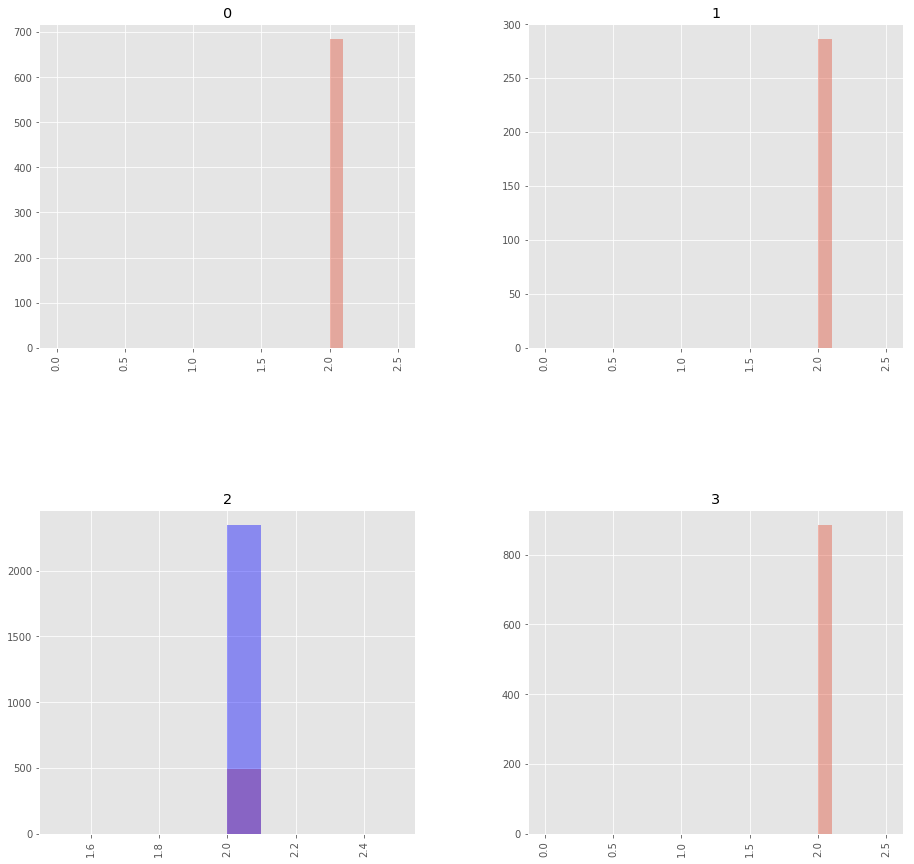

In [8]:
axes = df.regression.hist(by=df.y_true, figsize=(15,15), alpha=0.4)
print(axes)

for i, ax in enumerate(axes.flat):
    df.regression[df.y_pred==i].hist(ax=ax, color='blue', alpha=0.4)

204-19-6
204-20-1Z
204-20-6a
204-24a-6


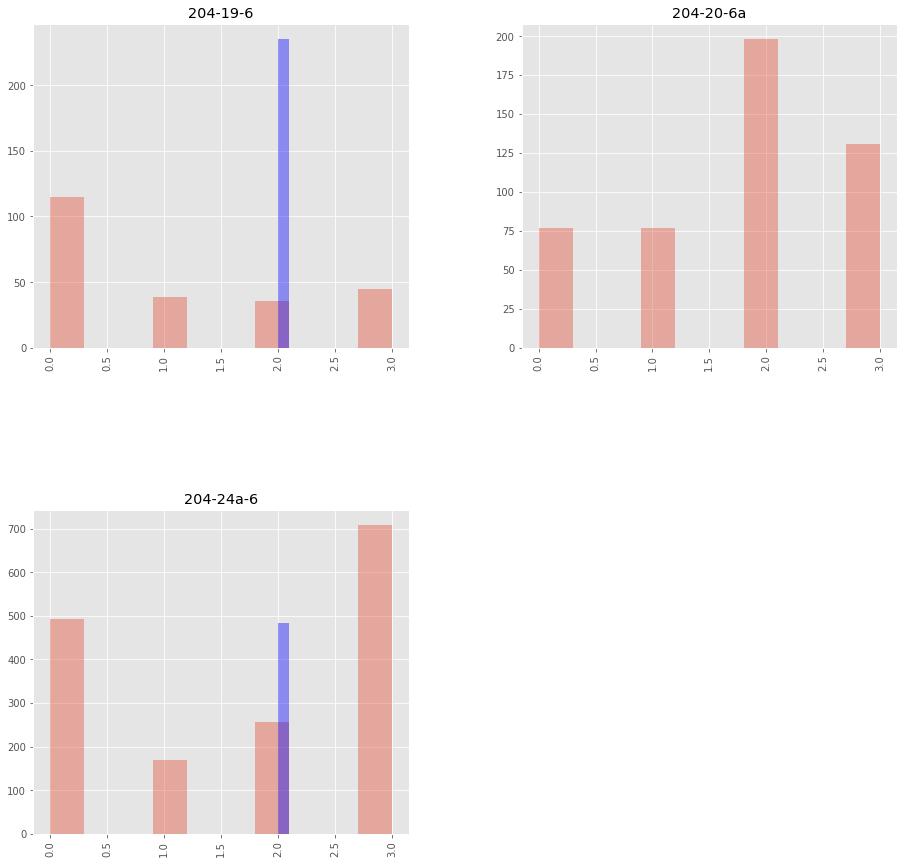

In [9]:
axes = df.y_true.hist(by=df.well_name, figsize=(15,15), alpha=0.4)

well_names = ["204-19-6", "204-20-1Z", "204-20-6a", "204-24a-6", "205-21b-3"]

for i, (ax, name) in enumerate(zip(axes.flat, well_names)):
    print(name)
    df.y_pred[df.well_name==name].hist(ax=ax, color='blue', alpha=0.4)

In [ ]:
fdset.well_names

In [ ]:
fdset.test_well_names

In [ ]:
np.arange(30).reshape(5, 3, 2)

In [ ]:
np.arange(30).reshape(5, 3, 2).reshape(-1, 2).reshape(5, 3 ,2)